In [1]:
import os
import sys
import pickle

import math
from datetime import timezone, datetime

import joblib
import matplotlib.pyplot as plt
import mplfinance as mpf
import numba
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
import seaborn as sns
import talib

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit

In [2]:
from timescaledb_util import TimeScaleDBUtil

# TimescaleDB用のユーティリティライブラリの設定
_pg_config = {
        'user': os.environ['POSTGRES_USER'],
        'password': os.environ['POSTGRES_PASSWORD'],
        'host': os.environ['POSTGRES_HOST'],
        'port': os.environ['POSTGRES_PORT'],
        'database': os.environ['POSTGRES_DATABASE']
    }

# TimescaleDBアクセス用のユーティリティオブジェクトを作成
_dbutil = TimeScaleDBUtil(user = _pg_config['user'], password = _pg_config['password'], host = _pg_config['host'], port = _pg_config['port'], database = _pg_config['database'])

In [3]:
# ドルバー読み込み用の関数
def load_dollarbar(table_str, from_str, to_str, fee):
    _sql = f"SELECT * FROM \"{table_str}\" WHERE datetime >= '{from_str}' AND datetime < '{to_str}' ORDER BY dollar_cumsum ASC"
    df = _dbutil.read_sql_query(sql = _sql)
    df['fee'] = fee
    df = df[['datetime', 'open', 'high', 'low', 'close', 'dollar_volume', 'dollar_buy_volume', 'dollar_sell_volume', 'dollar_liquidation_buy_volume', 'dollar_liquidation_sell_volume', 'fee']]
    df.columns = ['Datetime', 'Open', 'High', 'Low', 'Close', 'dollar_volume', 'dollar_buy_volume', 'dollar_sell_volume', 'dollar_liquidation_buy_volume', 'dollar_liquidation_sell_volume', 'fee']
    df = df.set_index("Datetime")    
    return df

# 全区間のドルバーの読み込みと保存
df = load_dollarbar('ftx_btc-perp_dollarbar_5000000', '2021-01-01 00:00:00.000+00', '2023-01-01 00:00:00.000+00', 0.02/100)
df.to_pickle('df_ohlcv.pkl')

In [4]:
# Richmanbtcさんのチュートリアルから取った関数
@numba.njit
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    y = entry_price.copy()
    y[:] = np.nan
    force_entry_time = entry_price.copy()
    force_entry_time[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                force_entry_time[i] = j - i
                break
    return y, force_entry_time

def calc_buysell(df, pips = 1, atr_mux = 0.5, atr_range=14):
    # ATRで指値距離を計算します
    df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=atr_range)
    limit_price_dist = df['ATR'] * atr_mux
    limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips
    
    # 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
    df['buy_price'] = df['Close'] - limit_price_dist
    df['sell_price'] = df['Close'] + limit_price_dist
    
    # Force Entry Priceの計算
    df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
        entry_price=df['buy_price'].values,
        lo=df['Low'].values,
        pips=pips,
    )

    # calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
    df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
        entry_price=-df['sell_price'].values,
        lo=-df['High'].values, # 売りのときは高値
        pips=pips,
    )
    df['sell_fep'] *= -1
    
    horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
    fee = df['fee'] # maker手数料
    
    # 指値が約定したかどうか (0, 1)
    df['buy_executed'] = ((df['buy_price'] / pips).round() > (df['Low'].shift(-1) / pips).round()).astype('float64')
    df['sell_executed'] = ((df['sell_price'] / pips).round() < (df['High'].shift(-1) / pips).round()).astype('float64')
    
    # yを計算
    df['y_buy'] = np.where(
        df['buy_executed'],
        df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
        0
    )
    df['y_sell'] = np.where(
        df['sell_executed'],
        -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
        0
    )

    # バックテストで利用する取引コストを計算
    df['buy_cost'] = np.where(
        df['buy_executed'],
        df['buy_price'] / df['Close'] - 1 + fee,
        0
    )
    df['sell_cost'] = np.where(
        df['sell_executed'],
        -(df['sell_price'] / df['Close'] - 1) + fee,
        0
    )
    
    return df

# Richmanbtcさんのチュートリアルから取った特徴量計算関数
def calc_features(df):
    open = df['Open']
    high = df['High']
    low = df['Low']
    close = df['Close']
    volume = df['dollar_buy_volume'] + df['dollar_sell_volume']
    
    hilo = (high + low) / 2
    df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] -= hilo
    df['BBANDS_middleband'] -= hilo
    df['BBANDS_lowerband'] -= hilo
    df['DEMA'] = talib.DEMA(close, timeperiod=30) - hilo
    df['EMA'] = talib.EMA(close, timeperiod=30) - hilo
    df['HT_TRENDLINE'] = talib.HT_TRENDLINE(close) - hilo
    df['KAMA'] = talib.KAMA(close, timeperiod=30) - hilo
    df['MA'] = talib.MA(close, timeperiod=30, matype=0) - hilo
    df['MIDPOINT'] = talib.MIDPOINT(close, timeperiod=14) - hilo
    df['SMA'] = talib.SMA(close, timeperiod=30) - hilo
    df['T3'] = talib.T3(close, timeperiod=5, vfactor=0) - hilo
    df['TEMA'] = talib.TEMA(close, timeperiod=30) - hilo
    df['TRIMA'] = talib.TRIMA(close, timeperiod=30) - hilo
    df['WMA'] = talib.WMA(close, timeperiod=30) - hilo

    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
    df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
    df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
    df['BOP'] = talib.BOP(open, high, low, close)
    df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
    df['DX'] = talib.DX(high, low, close, timeperiod=14)
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    # skip MACDEXT MACDFIX たぶん同じなので
    df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
    df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
    df['MOM'] = talib.MOM(close, timeperiod=10)
    df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
    df['RSI'] = talib.RSI(close, timeperiod=14)
    df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['TRIX'] = talib.TRIX(close, timeperiod=30)
    df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)

    df['AD'] = talib.AD(high, low, close, volume)
    df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    df['OBV'] = talib.OBV(close, volume)

    df['ATR'] = talib.ATR(high, low, close, timeperiod=14)
    df['NATR'] = talib.NATR(high, low, close, timeperiod=14)
    df['TRANGE'] = talib.TRANGE(high, low, close)

    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
    df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)

    df['BETA'] = talib.BETA(high, low, timeperiod=5)
    df['CORREL'] = talib.CORREL(high, low, timeperiod=30)
    df['LINEARREG'] = talib.LINEARREG(close, timeperiod=14) - close
    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)
    df['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14)
    df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1)
    
    # ドルバー由来の特徴量を追加
    df['TIME'] = df.index
    df['DELTA_TIME'] = df['TIME'].diff()
    df['DELTA_TIME'] = df['DELTA_TIME'].view(int) / 1_000_000_000 # 単位は秒
    df['DELTA_TIME_T-1'] = df['DELTA_TIME'].shift(1)
    df['DELTA_TIME_T-2'] = df['DELTA_TIME'].shift(2)
    df['DELTA_TIME_T-3'] = df['DELTA_TIME'].shift(3)
    df['DELTA_TIME_T-4'] = df['DELTA_TIME'].shift(4)
    
    df['DELTA_TIME_T-1/T'] = df['DELTA_TIME_T-1'] / df['DELTA_TIME']
    df['DELTA_TIME_T-2/T'] = df['DELTA_TIME_T-2'] / df['DELTA_TIME']
    df['DELTA_TIME_T-3/T'] = df['DELTA_TIME_T-3'] / df['DELTA_TIME']
    df['DELTA_TIME_T-4/T'] = df['DELTA_TIME_T-4'] / df['DELTA_TIME']
    
    df['BUY_RATIO'] = df['dollar_buy_volume'] / (df['dollar_buy_volume'] + df['dollar_sell_volume'])
    df['BUY_RATIO_T-1'] = df['BUY_RATIO'].shift(1)
    df['BUY_RATIO_T-2'] = df['BUY_RATIO'].shift(2)
    df['BUY_RATIO_T-3'] = df['BUY_RATIO'].shift(3)
    df['BUY_RATIO_T-4'] = df['BUY_RATIO'].shift(4)

    df['SELL_RATIO'] = df['dollar_sell_volume'] / (df['dollar_buy_volume'] + df['dollar_sell_volume'])
    df['SELL_RATIO_T-1'] = df['SELL_RATIO'].shift(1)
    df['SELL_RATIO_T-2'] = df['SELL_RATIO'].shift(2)
    df['SELL_RATIO_T-3'] = df['SELL_RATIO'].shift(3)
    df['SELL_RATIO_T-4'] = df['SELL_RATIO'].shift(4)

    df['LIQUIDATION_BUY_RATIO'] = df['dollar_liquidation_buy_volume'] / (df['dollar_buy_volume'] + df['dollar_sell_volume'])
    df['LIQUIDATION_BUY_RATIO_T-1'] = df['LIQUIDATION_BUY_RATIO'].shift(1)
    df['LIQUIDATION_BUY_RATIO_T-2'] = df['LIQUIDATION_BUY_RATIO'].shift(2)
    df['LIQUIDATION_BUY_RATIO_T-3'] = df['LIQUIDATION_BUY_RATIO'].shift(3)
    df['LIQUIDATION_BUY_RATIO_T-4'] = df['LIQUIDATION_BUY_RATIO'].shift(4)

    df['LIQUIDATION_SELL_RATIO'] = df['dollar_liquidation_sell_volume'] / (df['dollar_buy_volume'] + df['dollar_sell_volume'])
    df['LIQUIDATION_SELL_RATIO_T-1'] = df['LIQUIDATION_SELL_RATIO'].shift()
    df['LIQUIDATION_SELL_RATIO_T-2'] = df['LIQUIDATION_SELL_RATIO'].shift(2)
    df['LIQUIDATION_SELL_RATIO_T-3'] = df['LIQUIDATION_SELL_RATIO'].shift(3)
    df['LIQUIDATION_SELL_RATIO_T-4'] = df['LIQUIDATION_SELL_RATIO'].shift(4)
    
    return df.dropna()

# p平均法 https://note.com/btcml/n/n0d9575882640
def calc_p_mean(x, n):
    ps = []
    for i in range(n):
        x2 = x[i * x.size // n:(i + 1) * x.size // n]
        if np.std(x2) == 0:
            ps.append(1)
        else:
            t, p = ttest_1samp(x2, 0,  alternative='greater')
            if t > 0:
                ps.append(p)
            else:
                ps.append(1)
    return np.mean(ps)

def calc_p_mean_type1_error_rate(p_mean, n):
    return (p_mean * n) ** n / math.factorial(n)

@numba.njit
def backtest(cl=None, hi=None, lo=None, pips=None, buy_entry=None, sell_entry=None, buy_cost=None, sell_cost=None):
    n = cl.size
    y = cl.copy() * 0.0
    poss = cl.copy() * 0.0
    ret = 0.0
    pos = 0.0
    for i in range(n):
        prev_pos = pos
        
        # exit
        if buy_cost[i]:
            vol = np.maximum(0, -prev_pos)
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_cost[i]:
            vol = np.maximum(0, prev_pos)
            ret -= sell_cost[i] * vol
            pos -= vol

        # entry
        if buy_entry[i] and buy_cost[i]:
            vol = np.minimum(1.0, 1 - prev_pos) * buy_entry[i]
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_entry[i] and sell_cost[i]:
            vol = np.minimum(1.0, prev_pos + 1) * sell_entry[i]
            ret -= sell_cost[i] * vol
            pos -= vol
        
        if i + 1 < n:
            ret += pos * (cl[i + 1] / cl[i] - 1)
            
        y[i] = ret
        poss[i] = pos
        
    return y, poss

In [5]:
# 学習に利用しない特徴量をコメントアウトする
features = sorted([
#    'ADX', 'ADXR', 'APO',
#    'AROON_aroondown', 'AROON_aroonup', 'AROONOSC',
#    'CCI',
#    'DX',
#    'MACD_macd', 'MACD_macdsignal', 'MACD_macdhist',
#    'MFI',
#    'MINUS_DI', 'MINUS_DM',
#    'MOM',
#    'PLUS_DI', 'PLUS_DM',
#    'RSI',
#    'STOCH_slowk', 'STOCH_slowd', 'STOCHF_fastk', 'STOCHRSI_fastd',
#    'ULTOSC',
#    'WILLR',
#    'ADOSC',
#    'NATR', # NATRはいつもfeature importanceが非常に高くなってしまう
#    'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR_inphase', 'HT_PHASOR_quadrature', 'HT_TRENDMODE', 'HT_TRENDLINE',
#    'BETA',
#    'LINEARREG', 'LINEARREG_ANGLE', 'LINEARREG_INTERCEPT', 'LINEARREG_SLOPE',
#    'STDDEV',
#    'BBANDS_upperband', 'BBANDS_middleband', 'BBANDS_lowerband',
#    'DEMA', 'EMA', 'KAMA', 'MA',
#    'MIDPOINT',
#    'T3',
#    'TEMA', 'TRIMA', 'WMA',

    # richmanbtcさんのチュートリアルには存在しなかった特徴量
    'BUY_RATIO', 'BUY_RATIO_T-1', 'BUY_RATIO_T-2', 'BUY_RATIO_T-3', 'BUY_RATIO_T-4',
    'SELL_RATIO', 'SELL_RATIO_T-1', 'SELL_RATIO_T-2', 'SELL_RATIO_T-3', 'SELL_RATIO_T-4',
    'LIQUIDATION_BUY_RATIO', 'LIQUIDATION_BUY_RATIO_T-1', 'LIQUIDATION_BUY_RATIO_T-2', 'LIQUIDATION_BUY_RATIO_T-3', 'LIQUIDATION_BUY_RATIO_T-4',
    'LIQUIDATION_SELL_RATIO', 'LIQUIDATION_SELL_RATIO_T-1', 'LIQUIDATION_SELL_RATIO_T-2', 'LIQUIDATION_SELL_RATIO_T-3', 'LIQUIDATION_SELL_RATIO_T-4',
    'DELTA_TIME_T-1/T', 'DELTA_TIME_T-2/T', 'DELTA_TIME_T-3/T', 'DELTA_TIME_T-4/T',
])

print(features)

['BUY_RATIO', 'BUY_RATIO_T-1', 'BUY_RATIO_T-2', 'BUY_RATIO_T-3', 'BUY_RATIO_T-4', 'DELTA_TIME_T-1/T', 'DELTA_TIME_T-2/T', 'DELTA_TIME_T-3/T', 'DELTA_TIME_T-4/T', 'LIQUIDATION_BUY_RATIO', 'LIQUIDATION_BUY_RATIO_T-1', 'LIQUIDATION_BUY_RATIO_T-2', 'LIQUIDATION_BUY_RATIO_T-3', 'LIQUIDATION_BUY_RATIO_T-4', 'LIQUIDATION_SELL_RATIO', 'LIQUIDATION_SELL_RATIO_T-1', 'LIQUIDATION_SELL_RATIO_T-2', 'LIQUIDATION_SELL_RATIO_T-3', 'LIQUIDATION_SELL_RATIO_T-4', 'SELL_RATIO', 'SELL_RATIO_T-1', 'SELL_RATIO_T-2', 'SELL_RATIO_T-3', 'SELL_RATIO_T-4']


In [6]:
import optuna
import math

# ATRの指値幅を変数として、取引数とリターンの積を最大化するOptunaの最適化対象の関数
def target_function(x, y):
    df = pd.read_pickle('df_ohlcv.pkl')
    #df = calc_features(df)
    df = calc_buysell(df, pips = 1, atr_mux = x, atr_range=y)
    
    y_buy = (df['buy_executed'] * df['y_buy']).sum()
    y_sell = (df['sell_executed'] * df['y_sell']).sum()
    
    #print(f'y_buy = {y_buy}, y_sell = {y_sell}, atr_mux = {x}, atr_range = {y}')
    return y_buy + y_sell

# Optunaの最適化目的関数
def objective(trial):
    x = trial.suggest_uniform('x', 0.5, 2.0)
    y = trial.suggest_int('y', 14, 14)
    score = target_function(x, y)
    return score

# 最適化を実施
#study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=400)
#atr_mux = study.best_params['x']
#atr_range = study.best_params['y']
#optuna.visualization.plot_slice(study, params=["x"])

# 以前の学習結果を利用して最適化をスキップ
# 10_000_000ドルバー : Trial 74 finished with value: 16193.839450781088 and parameters: {'x': 1.4788760220633528}. Best is trial 74 with value: 16193.839450781088
# 5_000_000ドルバー : Trial 193 finished with value: 7080.370047388982 and parameters: {'x': 2.1472956042094262}. Best is trial 193 with value: 7080.370047388982.
atr_mux = 1.0
atr_range = 4

In [100]:
from sklearn.metrics import mean_squared_error

# パフォーマンスを表示する関数
def display_performance(df, subtitle):
    fig, ax = plt.subplots(2, 2, figsize=(12, 12))
    plt.subplots_adjust(wspace=0.2, hspace=0.3)
    
    df['buy_executed'].rolling(1000).mean().plot(label='Buy', ax=ax[0, 0])
    df['sell_executed'].rolling(1000).mean().plot(label='Sell', ax=ax[0, 0])
    ax[0, 0].set_title(f'Execution probability ({subtitle})')
    ax[0, 0].legend()

    df['buy_fet'].rolling(1000).mean().plot(label='Buy', ax=ax[0, 1])
    df['sell_fet'].rolling(1000).mean().plot(label='Sell',  ax=ax[0, 1])
    ax[0, 1].set_title(f'Average time until exit ({subtitle})')
    ax[0, 1].legend()

    df['buy_fet'].hist(alpha=0.3, label='Buy', ax=ax[1, 0])
    df['sell_fet'].hist(alpha=0.3, label='Sell', ax=ax[1, 0])
    ax[1, 0].set_title(f'Time distribution until exit ({subtitle})')
    ax[1, 0].legend()

    (df['buy_executed'] * df['y_buy']).cumsum().plot(label='Buy', ax=ax[1, 1])
    (df['sell_executed'] * df['y_sell']).cumsum().plot(label='Sell', ax=ax[1, 1])
    (df['buy_executed'] * df['y_buy'] + df['sell_executed'] * df['y_sell']).cumsum().plot(label='Buy+Sell', ax=ax[1, 1])
    ax[1, 1].set_title(f'Cumulative return ({subtitle})')
    ax[1, 1].legend()
    fig.show()
    
    # 数値を表示する
    buy_return = (df["buy_executed"] * df["y_buy"]).sum()
    sell_return = (df["sell_executed"] * df["y_sell"]).sum()
    
    bar_count = len(df)
    
    buy_count = len(df[(df["buy_executed"] > 0)])
    sell_count = len(df[(df["sell_executed"] > 0)])
    
    positive_buy_count = len(df[(df["buy_executed"] > 0) & (df["y_buy"] > 0)])
    negative_buy_count = len(df[(df["buy_executed"] > 0) & (df["y_buy"] < 0)])
    
    positive_sell_count = len(df[(df["sell_executed"] > 0) & (df["y_sell"] > 0)])
    negative_sell_count = len(df[(df["sell_executed"] > 0) & (df["y_sell"] < 0)])

    positive_buy_return = df.loc[(df["buy_executed"] > 0) & (df["y_buy"] > 0), "y_buy"].sum()
    negative_buy_return = df.loc[(df["buy_executed"] > 0) & (df["y_buy"] < 0), "y_buy"].sum()
                           
    positive_sell_return = df.loc[(df["sell_executed"] > 0) & (df["y_sell"] > 0), "y_sell"].sum()
    negative_sell_return = df.loc[(df["sell_executed"] > 0) & (df["y_sell"] < 0), "y_sell"].sum()

    print(f'バーの数 {bar_count}本')
    print(f'買いリターン合計 {buy_return * 100:.2f}% 売りリターン合計 {sell_return*100:.2f}% 合計リターン {(buy_return + sell_return)*100:.2f}%')
    print(f'買い {buy_count}回, 売り {sell_count}回')
    print(f'リターンが正の買い {positive_buy_count}回 ({(positive_buy_count / buy_count)*100:.02f} %), リターンが負の買い {negative_buy_count}回 ({(negative_buy_count / buy_count)*100:.02f} %)')
    print(f'リターンが正の売り {positive_sell_count}回 ({(positive_sell_count / sell_count)*100:.02f} %), リターンが負の売り {negative_sell_count}回 ({(negative_sell_count / sell_count)*100:.02f} %)')
    print(f'正の買いリターン平均 {positive_buy_return / positive_buy_count * 100:.03f} %, 負の買いリターン平均 {negative_buy_return / negative_buy_count * 100:.03f} %')
    print(f'正の売りリターン平均 {positive_sell_return / positive_sell_count * 100:.03f} %, 負の売りリターン平均 {negative_sell_return / negative_sell_count * 100:.03f} %')
    print(f'買いリターン平均 {(buy_return / buy_count)*100:.03f} %, 売りリターン平均 {(sell_return / sell_count)*100:.03f} %')

def display_true_vs_pred(series_true, series_pred, subtitle):
    df = pd.DataFrame({'true': series_true, 'pred': series_pred}).dropna()
    corr = np.corrcoef(df['true'], df['pred'])
    pred_std = df['pred'].std()
    pred_mean = df['pred'].mean()
    true_std = df['true'].std()
    true_mean = df['true'].mean()
    
    pred_max = pred_mean + 4*pred_std
    pred_min = pred_mean - 4*pred_std
    true_max = true_mean + 4*true_std
    true_min = true_mean - 4*true_std
    
    fig, ax = plt.subplots(2, 2, sharex='col', sharey = 'row',
                           gridspec_kw={'width_ratios': [2, 0.5], 'height_ratios': [2, 0.5]}, figsize=(6, 6))
    
    # 予測値のレンジごとに真値の平均をプロットして比例関係があることを確認する
    pred_sections = []
    true_means = []
    for i in range(9):
        _df = df[(df['pred'] >= pred_min + pred_std*i) & (df['pred'] >= pred_min + pred_std*(i+1))]
        pred_sections.append(pred_min + pred_std*i)
        true_means.append(_df['true'].mean())

    # 散布図をプロットする (予測対象にならなかったtrue値は0になっているのでそれを除外していることに注意)
    ax[0, 0].scatter(df.loc[df['true'] != 0, 'pred'], df.loc[df['true'] != 0, 'true'], s = 1)
    ax[0, 0].step(pred_sections, true_means, 'red', where='pre')
    ax[0, 0].set_title(subtitle + f' (IC={corr[0][1]:0.4f})')
    ax[0, 0].set_xlabel("prediction")
    ax[0, 0].set_ylabel("truth")
    ax[0, 0].set_xlim([pred_min, pred_max])
    ax[0, 0].set_ylim([true_min, true_max])
    
    ax[1, 0].hist(df.loc[df['true'] != 0, 'pred'], bins=50, range=[pred_min, pred_max])
    ax[1, 0].invert_yaxis()

    ax[0, 1].hist(df.loc[df['true'] != 0, 'true'], bins=50, orientation='horizontal', range=[true_min, true_max])
    
    ax[1, 1].remove()
    
    fig.show()

def display_backtest(df):
    # バックテストで累積リターンと、ポジションを計算
    df['cum_ret'], df['poss'] = backtest(
        cl = df['Close'].values,
        buy_entry = df['y_pred_buy'].values > 0,
        sell_entry = df['y_pred_sell'].values > 0,
        buy_cost = df['buy_cost'].values,
        sell_cost = df['sell_cost'].values)
    
    fig, ax = plt.subplots(2, 2, figsize=(12, 12))
    plt.subplots_adjust(wspace=0.2, hspace=0.3)

    df['cum_ret'].plot(ax = ax[0, 0])
    ax[0, 0].set_title('Cumulative return')

    df['poss'].plot(ax = ax[0, 1])
    ax[0, 1].set_title('Position history')

    df['poss'].rolling(1000).mean().plot(ax = ax[1, 0])
    ax[1, 0].set_title('Position average history')
    
    df['poss'].diff(1).abs().dropna().cumsum().plot(ax = ax[1, 1])
    ax[1, 1].set_title('Cumulative trade volume')
    fig.show()

    print('t test')
    x = df['cum_ret'].diff(1).dropna()
    t, p = ttest_1samp(x, 0, alternative='greater')
    print('t value {}'.format(t))
    print('p value {}'.format(p))

    x = df['cum_ret'].diff(1).dropna()
    p_mean_n = 5
    p_mean = calc_p_mean(x, p_mean_n)
    print('p平均法 n = {}'.format(p_mean_n))
    print('p平均 {}'.format(p_mean))

バーの数 280210本
買いリターン合計 -1789.83% 売りリターン合計 -1824.09% 合計リターン -3613.93%
買い 38331回, 売り 38624回
リターンが正の買い 20247回 (52.82 %), リターンが負の買い 18083回 (47.18 %)
リターンが正の売り 20314回 (52.59 %), リターンが負の売り 18310回 (47.41 %)
正の買いリターン平均 0.241 %, 負の買いリターン平均 -0.369 %
正の売りリターン平均 0.251 %, 負の売りリターン平均 -0.379 %
買いリターン平均 -0.047 %, 売りリターン平均 -0.047 %


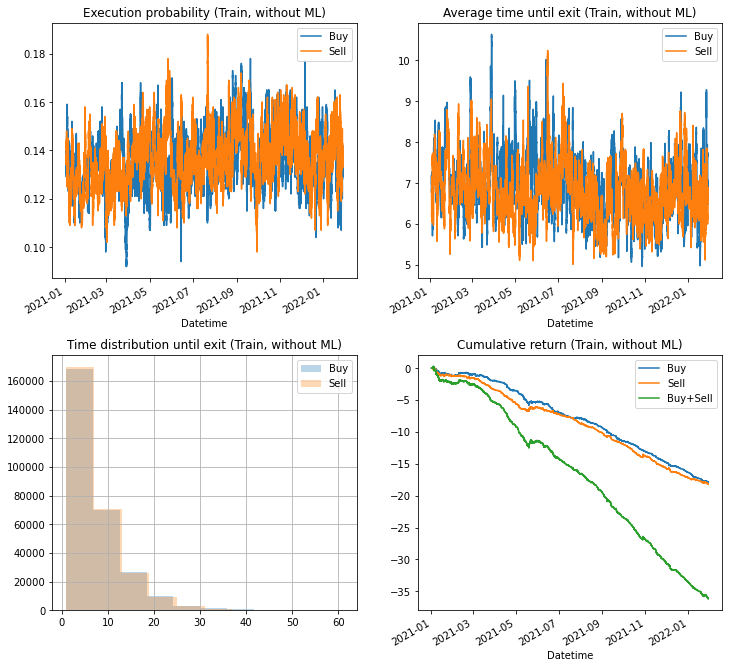

In [98]:
# Optunaの指値幅最適化結果に基づいて、学習区間でのパフォーマンス (MLフィルタ適応前) を表示
df_atr_optimized = pd.read_pickle('df_ohlcv.pkl')
df_atr_optimized = calc_features(df_atr_optimized)
df_atr_optimized = calc_buysell(df_atr_optimized, pips = 1, atr_mux = atr_mux, atr_range = atr_range)

# すべてのバーで売買しようとした結果を表示したいので、全ての行で正のリターンを予測したことにしておく
df_atr_optimized['y_pred_buy'] = 1.0
df_atr_optimized['y_pred_sell'] = 1.0

display_performance(df_atr_optimized, 'Train, without ML')

In [ ]:
# Optunaで最適なLightGBM学習パラメータを探して保存する
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from lightgbm import log_evaluation

# 固定するパラメータ
params = {
    'objective':'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'extra_trees': True,
    'deterministic': True,
    'force_row_wise': True
}

optuna.logging.set_verbosity(optuna.logging.ERROR)
df = pd.read_pickle('df_ohlcv.pkl')

# トレーニングデータに売買アクションと特徴量を追加
df_train = df[(df.index >= '2021-01-01 00:00:00+00') & (df.index < '2022-01-01 00:00:00+00')].copy()
df_train = calc_features(df_train)
df_train = calc_buysell(df_train, pips = 1, atr_mux = atr_mux)

# バリデーションデータに売買アクションと特徴量を追加
df_validation = df[(df.index >= '2022-01-01 00:00:00+00') & (df.index < '2023-01-01 00:00:00+00')].copy()
df_validation = calc_features(df_validation)
df_validation = calc_buysell(df_validation, pips = 1, atr_mux = atr_mux)

# トレーニングデータをLightGBMで使う形式に変換
lgb_buy_train = lgb.Dataset(df_train[features], df_train['y_buy'], free_raw_data=False)
lgb_sell_train = lgb.Dataset(df_train[features], df_train['y_sell'], free_raw_data=False)

# バリデーションデータをLightGBMで使う形式に変換
lgb_buy_validation = lgb.Dataset(df_validation[features], df_validation['y_buy'], reference=lgb_buy_train, free_raw_data=False)
lgb_sell_validation = lgb.Dataset(df_validation[features], df_validation['y_sell'], reference=lgb_sell_train, free_raw_data=False)

# OptunaでのLightGBM最適学習パラメータ探索
model_buy = lgb.train(params,
                      lgb_buy_train,
                      valid_sets=[lgb_buy_validation],
                      early_stopping_rounds = 100,
                      verbose_eval = 0,
                      show_progress_bar = False,
                      optuna_seed = 47)

model_sell = lgb.train(params,
                       lgb_sell_train, valid_sets=[lgb_sell_validation],
                       early_stopping_rounds = 100,
                       verbose_eval = 0,
                       show_progress_bar = False,
                       optuna_seed = 47)


# 最適学習パラメータを保存しておく (次回以降の学習で利用する…かも？)
buy_train_params = model_buy.params.copy()
print(f'Best buy params: {buy_train_params}')
with open('buy_train_params.pkl', 'wb') as f:
    pickle.dump(buy_train_params, f)

sell_train_params = model_sell.params.copy()
print(f'Best sell params: {sell_train_params}')
with open('sell_train_params.pkl', 'wb') as f:
    pickle.dump(sell_train_params, f)

バーの数 257687本
買いリターン合計 546.20% 売りリターン合計 202.49% 合計リターン 748.69%
買い 2891回, 売り 751回
リターンが正の買い 2107回 (72.88 %), リターンが負の買い 784回 (27.12 %)
リターンが正の売り 563回 (74.97 %), リターンが負の売り 188回 (25.03 %)
正の買いリターン平均 0.346 %, 負の買いリターン平均 -0.233 %
正の売りリターン平均 0.439 %, 負の売りリターン平均 -0.237 %
買いリターン平均 0.189 %, 売りリターン平均 0.270 %
t test
t value 19.983493466714933
p value 4.4774963316960336e-89
p平均法 n = 5
p平均 2.326687263495247e-10


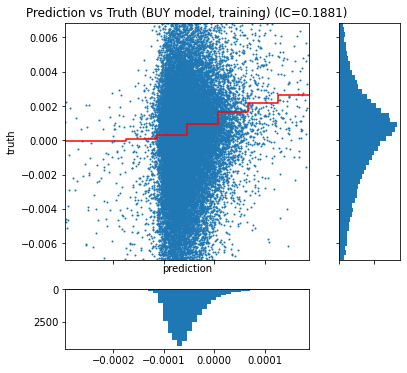

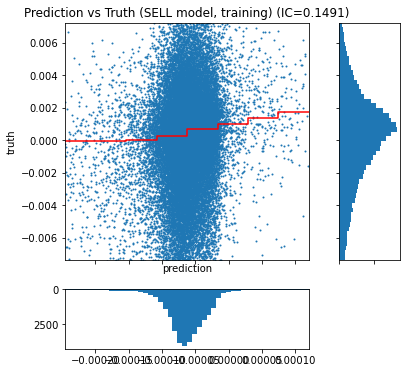

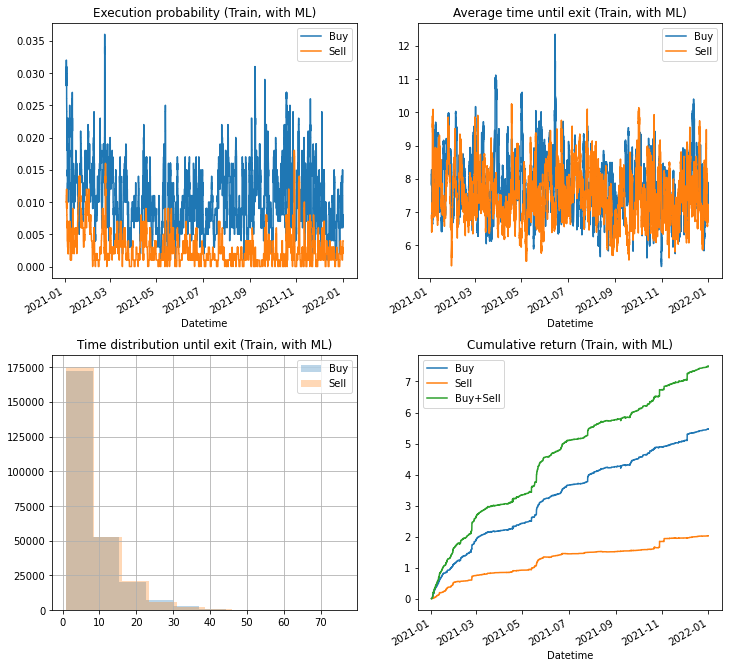

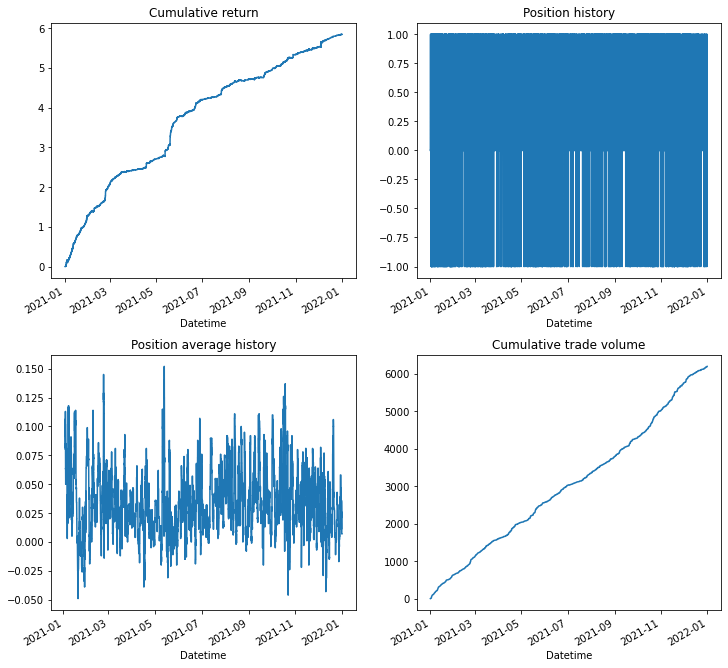

In [101]:
# 学習したモデルに学習区間を予測させて、抽出したパラメータがきちんと働いていることを確認する
# 学習した区間を予測するので、本来の予測性能を表してはいない
df_train['y_pred_buy'] = model_buy.predict(df_train[features], num_iteration=model_buy.best_iteration)
df_train['y_pred_sell'] = model_sell.predict(df_train[features], num_iteration=model_buy.best_iteration)

# 予測が正でない行では取引しないので、buy_executedとsell_executedをすべて0にしておく
df_train.loc[df_train['y_pred_buy'] <= 0, 'buy_executed'] = 0.0
df_train.loc[df_train['y_pred_sell'] <= 0, 'sell_executed'] = 0.0

display_true_vs_pred(df_train['y_buy'], df_train['y_pred_buy'], 'Prediction vs Truth (BUY model, training)')
display_true_vs_pred(df_train['y_sell'], df_train['y_pred_sell'], 'Prediction vs Truth (SELL model, training)')

# パフォーマンスの表示 (一応)
display_performance(df_train, 'Train, with ML')
display_backtest(df_train)

バーの数 22435本
買いリターン合計 10.08% 売りリターン合計 4.17% 合計リターン 14.25%
買い 214回, 売り 73回
リターンが正の買い 136回 (63.55 %), リターンが負の買い 78回 (36.45 %)
リターンが正の売り 44回 (60.27 %), リターンが負の売り 29回 (39.73 %)
正の買いリターン平均 0.259 %, 負の買いリターン平均 -0.323 %
正の売りリターン平均 0.307 %, 負の売りリターン平均 -0.322 %
買いリターン平均 0.047 %, 売りリターン平均 0.057 %
t test
t value 1.3525457738447904
p value 0.08810720943379803
p平均法 n = 5
p平均 0.38655664870329504


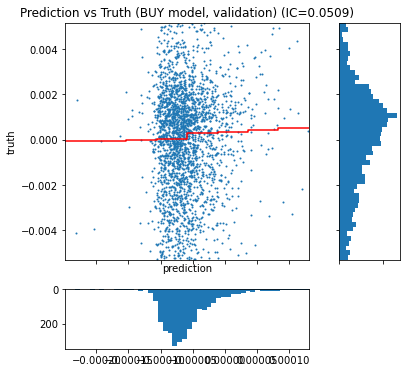

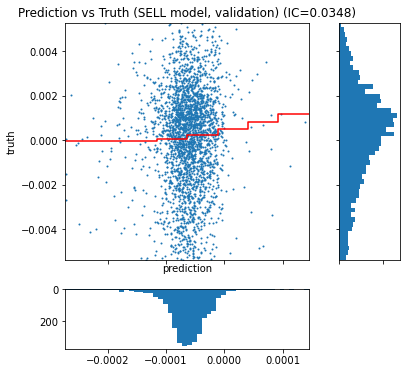

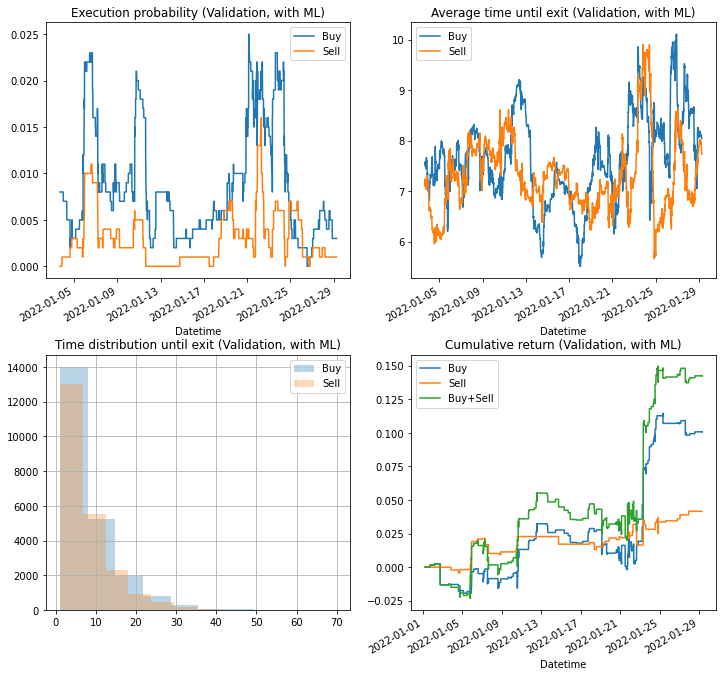

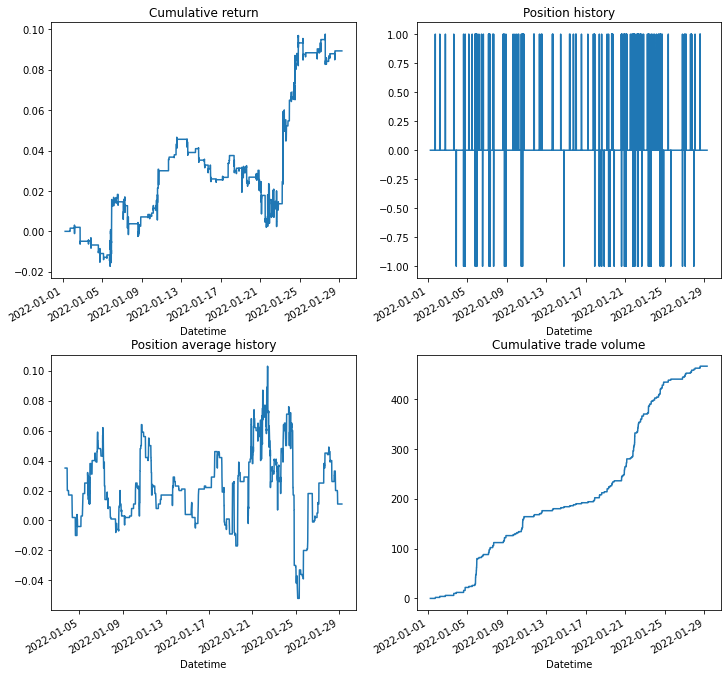

In [102]:
# テスト区間 (今はバリデーション区間と被っている) のデータに売買アクションと特徴量を追加
df_test = df[(df.index >= '2022-01-01 00:00:00+00') & (df.index < '2023-01-01 00:00:00+00')].copy()
df_test = calc_features(df_validation)
df_test = calc_buysell(df_validation, pips = 1, atr_mux = atr_mux)
df_test.loc[:, 'y_pred_buy'] = model_buy.predict(df_test[features], num_iteration=model_buy.best_iteration)
df_test.loc[:, 'y_pred_sell'] = model_sell.predict(df_test[features], num_iteration=model_sell.best_iteration)

# 予測が正でないフレームのbuy_executedをすべて0にしておく
df_test.loc[df_test['y_pred_buy'] <= 0, 'buy_executed'] = 0.0
df_test.loc[df_test['y_pred_sell'] <= 0, 'sell_executed'] = 0.0

# テスト区間でのリターンの真値とリターンの予測値を散布図で比較する
display_true_vs_pred(df_test['y_buy'], df_test['y_pred_buy'], 'Prediction vs Truth (BUY model, validation)')
display_true_vs_pred(df_test['y_sell'], df_test['y_pred_sell'], 'Prediction vs Truth (SELL model, validation)')

# パフォーマンスの表示
display_performance(df_test, 'Validation, with ML')
display_backtest(df_test)

<AxesSubplot:title={'center':'Feature importance (SELL model)'}, xlabel='Feature importance', ylabel='Features'>

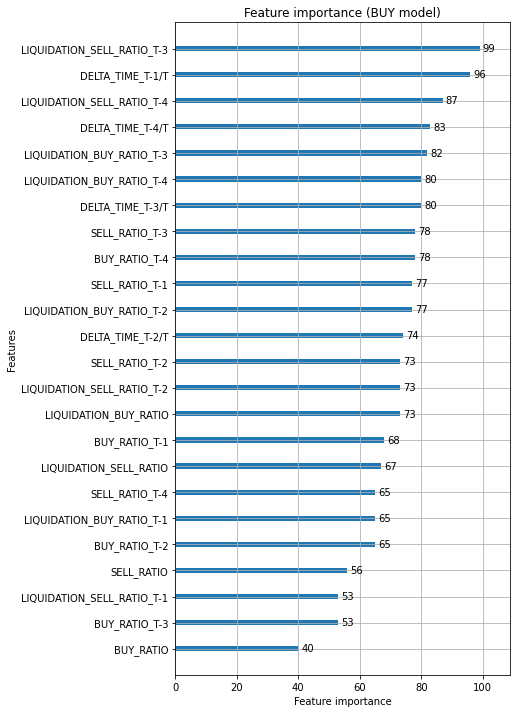

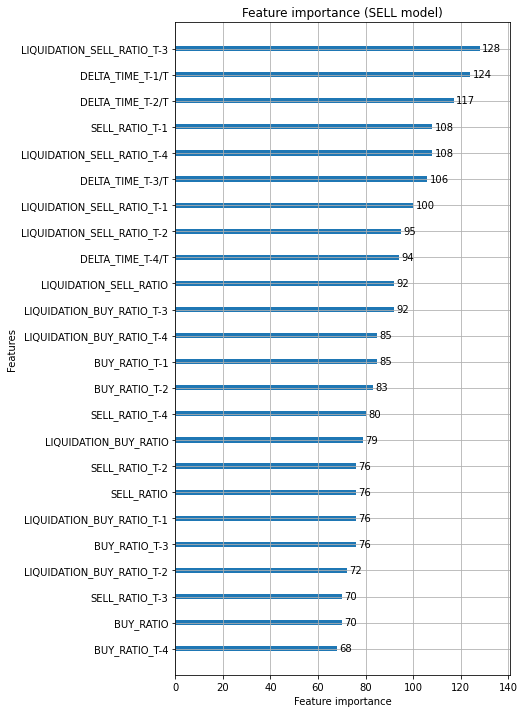

In [12]:
# 特徴量の重要度を表示する
lgb.plot_importance(model_buy, title='Feature importance (BUY model)', figsize=(6, 12))
lgb.plot_importance(model_sell, title='Feature importance (SELL model)', figsize=(6, 12))

In [ ]:
# RichmanbtcさんのCV部分

# データフレームをロード
df = pd.read_pickle('df_ohlcv.pkl')

# トレーニングデータに売買アクションと特徴量を追加
df_cv = df[(df.index >= '2021-01-01 00:00:00+00') & (df.index < '2023-01-01 00:00:00+00')].copy()
df_cv = calc_features(df_cv)
df_cv = calc_buysell(df_cv, pips = 1, atr_mux = atr_mux).dropna()

# 通常のCV
cv_indicies = list(KFold(5).split(df_cv))

# OOS予測値を計算
def my_cross_val_predict(X, y=None, cv=None):
    y_pred = y.copy()
    y_pred[:] = np.nan
    for train_idx, val_idx in cv:
        # トレーニングデータをLightGBMで使う形式に変換
        train_dataset = lgb.Dataset(X[train_idx], y[train_idx], free_raw_data=False)
        validation_dataset = lgb.Dataset(X[val_idx], y[val_idx], reference=train_dataset, free_raw_data=False)
        
        # OptunaでのLightGBM最適学習パラメータ探索
        model = lgb.train(params,
                          train_dataset,
                          valid_sets=[validation_dataset],
                          early_stopping_rounds = 100,
                          verbose_eval = 0,
                          show_progress_bar = False,
                          optuna_seed = 47)
        y_pred[val_idx] = model.predict(X[val_idx])
    return y_pred

df_cv['y_pred_buy'] = my_cross_val_predict(df_cv[features].values, df_cv['y_buy'].values, cv=cv_indicies)
df_cv['y_pred_sell'] = my_cross_val_predict(df_cv[features].values, df_cv['y_sell'].values, cv=cv_indicies)

バーの数 280192本
買いリターン合計 87.25% 売りリターン合計 4.18% 合計リターン 91.42%
買い 2710回, 売り 264回
リターンが正の買い 1620回 (59.78 %), リターンが負の買い 1090回 (40.22 %)
リターンが正の売り 150回 (56.82 %), リターンが負の売り 114回 (43.18 %)
正の買いリターン平均 0.293 %, 負の買いリターン平均 -0.356 %
正の売りリターン平均 0.297 %, 負の売りリターン平均 -0.354 %
買いリターン平均 0.032 %, 売りリターン平均 0.016 %
t test
t value 2.3125610950082147
p value 0.010373751757221883
p平均法 n = 5
p平均 0.16579834971628685


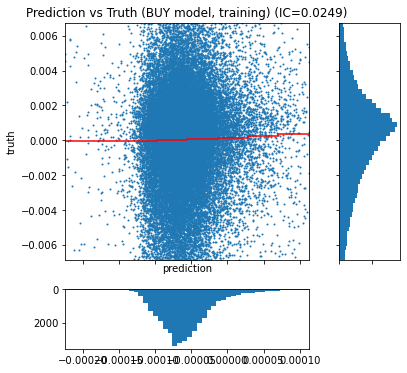

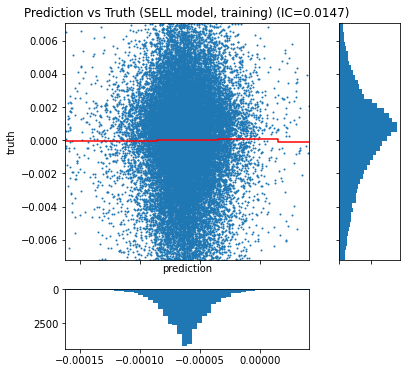

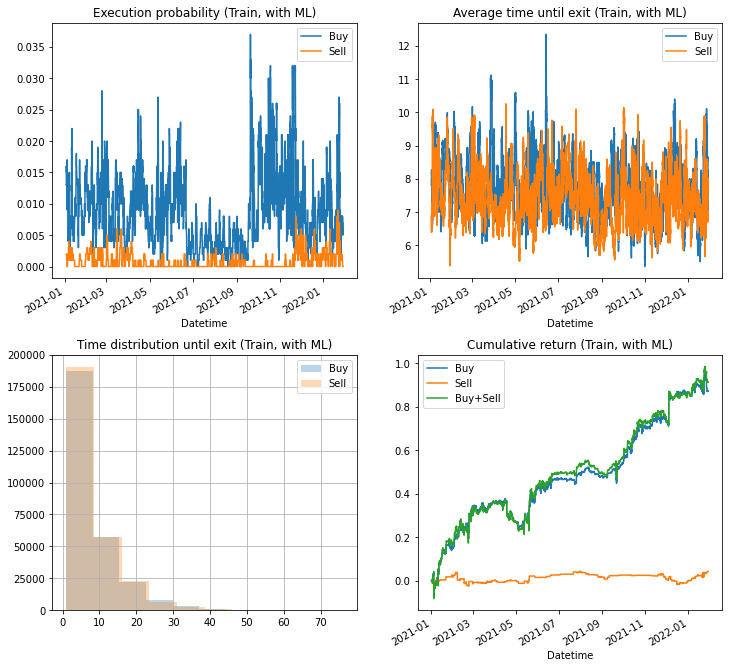

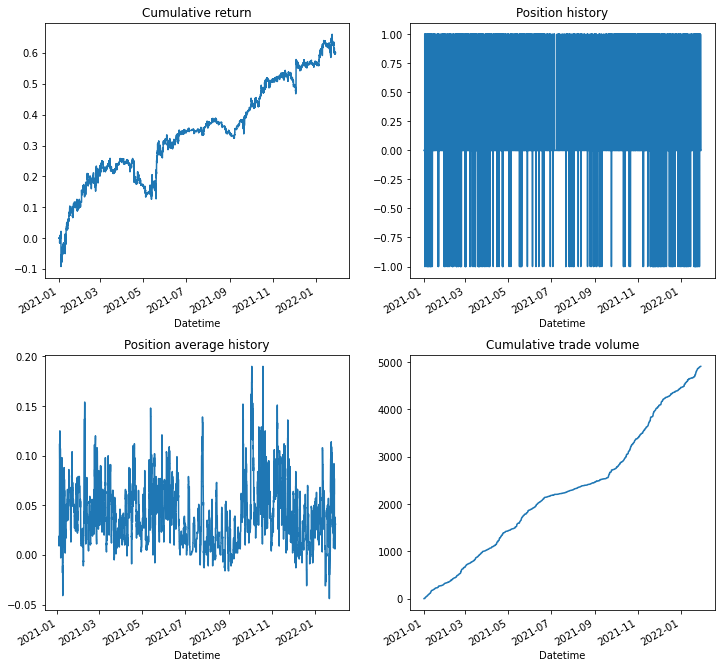

In [103]:
# 予測が正でない行では取引しないので、buy_executedとsell_executedをすべて0にしておく
df_cv.loc[df_cv['y_pred_buy'] <= 0, 'buy_executed'] = 0.0
df_cv.loc[df_cv['y_pred_sell'] <= 0, 'sell_executed'] = 0.0

display_true_vs_pred(df_cv['y_buy'], df_cv['y_pred_buy'], 'Prediction vs Truth (BUY model, training)')
display_true_vs_pred(df_cv['y_sell'], df_cv['y_pred_sell'], 'Prediction vs Truth (SELL model, training)')

# パフォーマンスの表示 (一応)
display_performance(df_cv, 'Train, with ML')
display_backtest(df_cv)